In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
import os
from glob import glob
from copy import copy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
random_seed = 0
np.random.seed(random_seed)

Load in the data training data, and separate it into training, validation, and test sets.

In [4]:
!ls -lh ../input

total 5.7M
-rw-r--r-- 1 root root 6.9K Apr 10 22:38 breed_labels.csv
-rw-r--r-- 1 root root   88 Apr 10 22:38 color_labels.csv
-rw-r--r-- 1 root root  285 Apr 10 22:38 state_labels.csv
drwxr-xr-x 2 root root 4.0K Apr 10 22:38 test
drwxr-xr-x 2 root root 512K Apr 10 22:40 test_images
drwxr-xr-x 2 root root 516K Apr 10 22:42 test_metadata
drwxr-xr-x 2 root root 132K Apr 10 22:43 test_sentiment
drwxr-xr-x 2 root root 4.0K Apr 10 22:43 train
drwxr-xr-x 2 root root 2.0M Apr 10 22:53 train_images
drwxr-xr-x 2 root root 2.1M Apr 10 23:03 train_metadata
drwxr-xr-x 2 root root 500K Apr 10 23:05 train_sentiment


In [5]:
all_data = pd.read_csv('../input/train/train.csv')
list(all_data.columns)

['Type',
 'Name',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'RescuerID',
 'VideoAmt',
 'Description',
 'PetID',
 'PhotoAmt',
 'AdoptionSpeed']

In [6]:
all_data.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


Create a new dataframe that is unique on the image, but repeats data per pet.

In [7]:
pet_data = all_data.set_index('PetID')

In [8]:
image_data = []

for image in glob('../input/train_images/*.jpg'):
    basename = os.path.basename(image)
    pet_id, _ = basename.rsplit('-')
    pet_row = pet_data.loc[pet_id].to_dict()
    pet_row['ImageFilename'] = image
    pet_row['ImageBasename'] = basename
    image_data.append(pet_row)
    
image_data = pd.DataFrame(image_data)

In [9]:
image_data.head()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,FurLength,Gender,Health,ImageBasename,ImageFilename,MaturitySize,Name,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt
0,1,120,20,195,2,0,0,2 males beagle & schnauzer for adoption. 10 & ...,1,0,1,1,1,8e0d65b3e-1.jpg,../input/train_images/8e0d65b3e-1.jpg,2,NaN,1.0,2,310cd86ec76858f026b95e421b833294,41326,2,1,1,0
1,3,8,266,0,1,2,7,Stray cat-Female 8mths. already spayed her on ...,1,0,1,2,1,6c9aeeb27-2.jpg,../input/train_images/6c9aeeb27-2.jpg,2,Kitten RA9,3.0,1,b770bac0ca797cf1433c48a35d30c4cb,41401,1,2,1,0
2,2,3,307,0,7,0,0,"Lovely, she came to my house yesterday. Trying...",1,0,2,2,1,33bfeb403-3.jpg,../input/train_images/33bfeb403-3.jpg,2,Lovely,3.0,1,df5dac2d2a3a28ba15c09cc65bc468de,41336,2,1,2,0
3,4,8,266,0,1,2,0,they r ol so cute :) it juz a matter me dun hv...,2,50,1,3,1,35f9818a7-9.jpg,../input/train_images/35f9818a7-9.jpg,2,Anak Nanya,14.0,3,f14c2cfebbbafbc9ed1f500d082f3ec3,41326,2,2,2,0
4,1,2,307,0,1,2,5,Very grateful that after a week of interview a...,2,0,1,3,1,c2aeb6a1f-17.jpg,../input/train_images/c2aeb6a1f-17.jpg,2,âª Moomoo's Babies âª,20.0,6,d73b10f170720b7edc3c12fc93b1fc63,41336,2,1,2,0


In [10]:
image_data['AdoptionSpeed']= image_data['AdoptionSpeed'].astype(str)

In [11]:
len(image_data), len(pet_data)

(58311, 14993)

Split the data into train, validation, and test sets.

In [12]:
y = image_data['AdoptionSpeed']

In [13]:
test_size = 0.2
validation_size = 0.2

# Split the training data off from leftover (i.e. validation and testing)
X_train, X_leftover, y_train, y_leftover = train_test_split(
    image_data, y, test_size=test_size, random_state=random_seed,
    stratify=y.values # stratify to ensure equal distribution of classes
)

# Determine how much the leftover section should be split to test
test_split = test_size / (test_size + validation_size)

X_validate, X_test, y_validate, y_test = train_test_split(
    X_leftover, y_leftover, test_size=test_split, random_state=random_seed,
    stratify=y_leftover.values # stratify to ensure equal distribution of classes
)

X_train.shape, X_validate.shape, X_test.shape

((46648, 25), (5831, 25), (5832, 25))

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
BATCH_SIZE = 50
VAL_BATCH = BATCH_SIZE * 2

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    X_train.reset_index(), # Need to reset index due to bug in flow_from_dataframe
    directory='../input/train_images/',
    x_col='ImageBasename',
    y_col='AdoptionSpeed',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

val_generator = val_datagen.flow_from_dataframe(
    X_validate.reset_index(), # Need to reset index due to bug in flow_from_dataframe
    directory='../input/train_images/',
    x_col='ImageBasename',
    y_col='AdoptionSpeed',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=VAL_BATCH,
)

Found 46648 images belonging to 5 classes.
Found 5831 images belonging to 5 classes.


In [17]:
from collections import Counter
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}        

In [18]:
class_weights


{1: 1.427176036466247,
 2: 1.0,
 4: 1.1796896025836547,
 3: 1.0915580642483607,
 0: 12.064220183486238}

In [19]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [20]:
# import regularizer
from keras import regularizers

from keras.regularizers import l1
# instantiate regularizer
reg = l1(0.001)

# example of l1 norm on activity from a cnn layer
from keras.layers import Conv2D
from keras.regularizers import l1

In [21]:
base_model = DenseNet121(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.
33193984/33188688 [==============================] - 1s 0us/step


In [22]:
x = base_model.output
x = Dense(1024, activation='relu',
          activity_regularizer=l1(0.001)
         )(x)
predictions = Dense(5, activation='softmax')(x)

In [23]:
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
for layer in base_model.layers:
    layer.trainable = False

In [25]:
from keras.optimizers import RMSprop
#rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-6)
rmsprop = RMSprop(lr=0.0001)

In [26]:
model.compile(
    optimizer= "rmsprop",
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [27]:
# TODO: Add batch size to train and validation
history = model.fit_generator(
    train_generator,
    epochs=5,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
#    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=len(X_validate)//VAL_BATCH,
#    validation_steps=100,
    # TODO: Add class weight
#    workers=4,
#    class_weight=class_weights,
    use_multiprocessing=True,
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
932/932 [==============================] - 853s 915ms/step - loss: 1.5259 - acc: 0.2819 - val_loss: 1.4793 - val_acc: 0.2819
Epoch 2/5
932/932 [==============================] - 750s 804ms/step - loss: 1.4647 - acc: 0.2818 - val_loss: 1.4585 - val_acc: 0.2820
Epoch 3/5
932/932 [==============================] - 748s 803ms/step - loss: 1.4518 - acc: 0.2833 - val_loss: 1.4560 - val_acc: 0.2926
Epoch 4/5
932/932 [==============================] - 749s 804ms/step - loss: 1.4440 - acc: 0.3081 - val_loss: 1.4543 - val_acc: 0.3146
Epoch 5/5
932/932 [==============================] - 746s 800ms/step - loss: 1.4385 - acc: 0.3148 - val_loss: 1.4561 - val_acc: 0.3123


Text(0.5, 1.0, 'Training and validation loss')

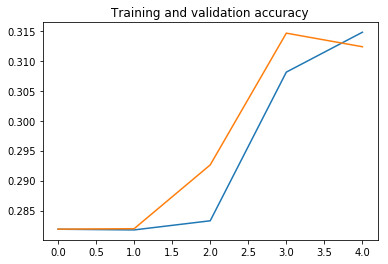

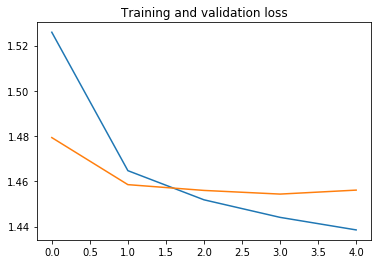

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')